# When do stop-loss rules stop losses?
Implementation by Abhishek Kumar (abhishek.kumar@berkeley.edu)

## Abstract

We propose a simple analytical framework to measure the value added or subtracted by stoploss rules—predetermined policies that reduce a portfolio’s exposure after reaching a certain
threshold of cumulative losses—on the expected return and volatility of an arbitrary portfolio strategy. Using daily futures price data, we provide an empirical analysis of stop-loss
policies applied to a buy-and-hold strategy using index futures contracts. At longer sampling frequencies, certain stop-loss policies can increase expected return while substantially
reducing volatility, consistent with their objectives in practical applications.

## Introduction

In this Jupyter Notebook, I will implement a basic stop loss algorithm based on the paper "When do stop-loss rules stop losses?". After implementing the core algorithm and calculating various metrics, such as the stop loss premium and stop loss ratio. I will then evaluate various scenarios in escalating complexity, beginning with random walks, then going to evaluating autoregressive series of power 1, and finally looking at market making regimes.

## Preprocessing
### Importing Neccessary Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [42]:
from policies.market_stop_loss import MarketStopLoss
import policies.obs_stop_loss as obs
from policies.utils import generate_random_walk, generate_autoregressive
import numpy as np
import matplotlib.pyplot as plt

### Loading the Dataset

In [3]:
toy_universe = ['AAPL', 'AMZN', 'MSFT']
toy_length = '5y'
toy_tick = '1d'

## Defintion 1: Stop Loss Model

In [5]:
simple_model = MarketStopLoss(toy_universe, toy_length, toy_tick, .05, .1, 30)

[*********************100%***********************]  3 of 3 completed


/Users/abhishekkumar/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/abhishekkumar/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/abhishekkumar/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


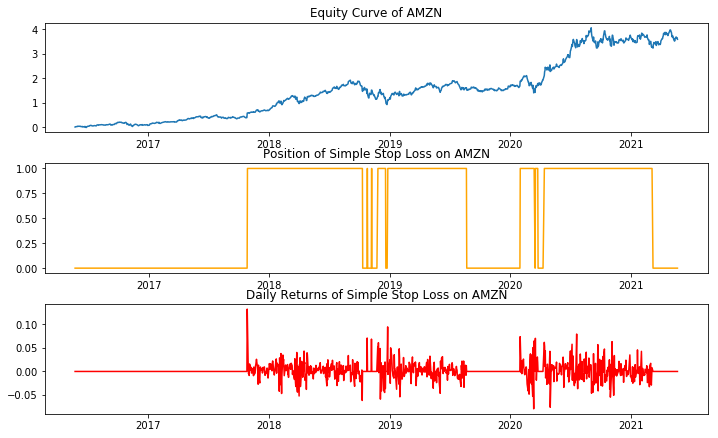

In [90]:
simple_model.perform_policy_individual('AMZN')
simple_model.plot_individual('AMZN')

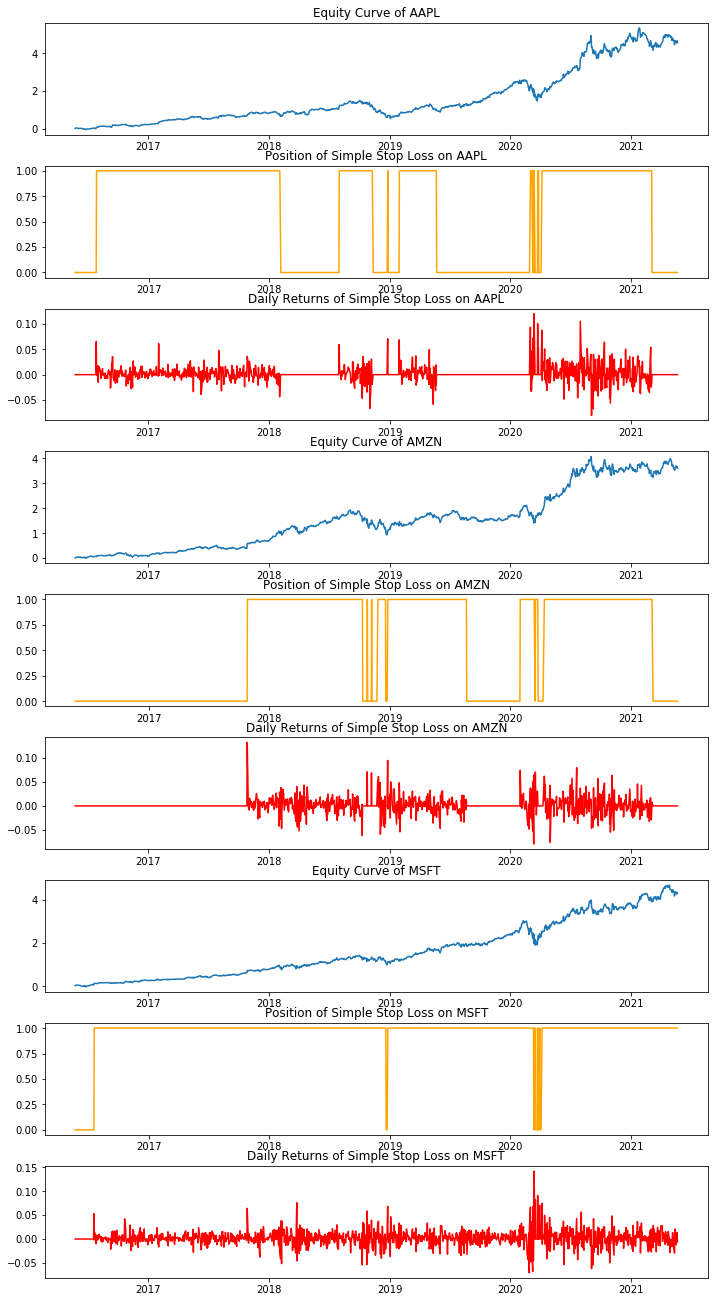

In [7]:
simple_model.plot()

## Defintion 2: Finding the Stop Loss Premium

In [8]:
simple_model.stop_ratio_individual('AMZN')

0.02985706913202794

In [9]:
simple_model.stop_premium_individual('AMZN')

0.01356492735783954

## Defition 3: Variance Difference of Stop Loss

In [10]:
simple_model.variance_difference_individual('AMZN')

0.00017503804643135155

## Proposition 1: Random Walk Hypothesis

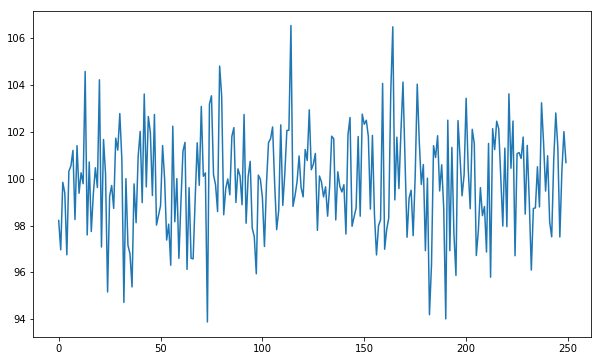

In [11]:
mu = 100
eps = 5
length = 250
random_walk = generate_random_walk(mu, eps, length)
plt.figure(figsize=(10,6))
plt.plot(np.arange(length), random_walk)

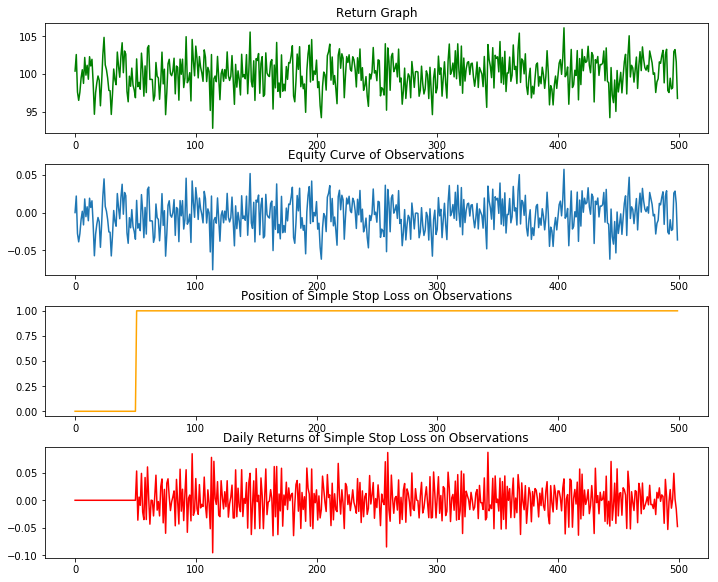

In [43]:
random_walk_stop_loss = obs.RandomWalkStopLoss(100, 5 , 500, .05, .3, 30, .03)
random_walk_stop_loss.plot()

## Proposition 2: Using AR(1)

In [13]:
mu = 100
eps = 5
length = 250

In [14]:
ar_random_walk = generate_autoregressive(mu, eps, 0, length)
ar_mean_reverting = generate_autoregressive(mu, eps, -np.random.rand(), length)
ar_momentum = generate_autoregressive(mu, eps, np.random.rand(), length)

Text(0.5,1,'Autoregressive model with rho > 1: Momentum')

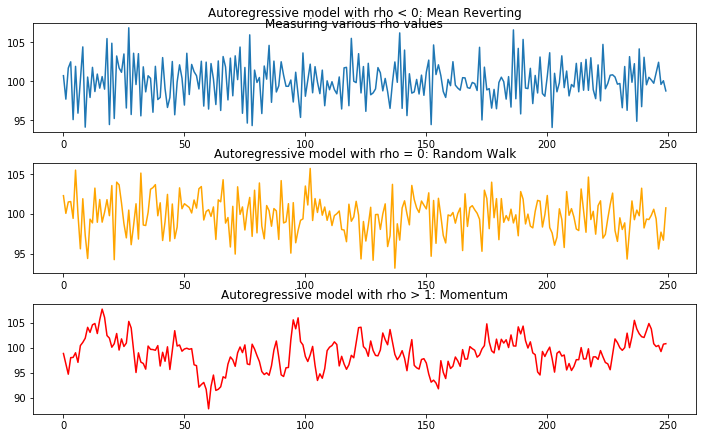

In [15]:
fig, axs = plt.subplots(3, figsize=(10,6))
fig.tight_layout(pad=1)
fig.suptitle('Measuring various rho values')
axs[0].plot(np.arange(length), ar_mean_reverting)
axs[0].set_title('Autoregressive model with rho < 0: Mean Reverting')
axs[1].plot(np.arange(length), ar_random_walk, color='orange')
axs[1].set_title('Autoregressive model with rho = 0: Random Walk')
axs[2].plot(np.arange(length), ar_momentum, color='r')
axs[2].set_title('Autoregressive model with rho > 1: Momentum')

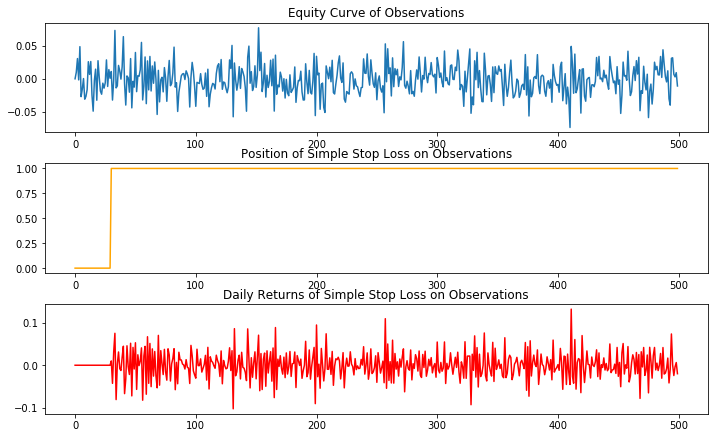

In [64]:
random_walk = obs.ARStopLoss(100, 5, 0, 500, .01, .3, 30, .03)
random_walk.plot()

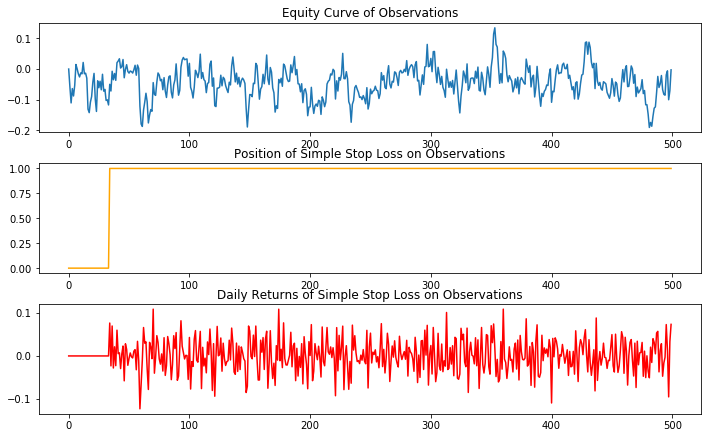

In [60]:
momentum = obs.ARStopLoss(100, 15, 0.75, 500, .01, .3, 30, .03)
momentum.plot()

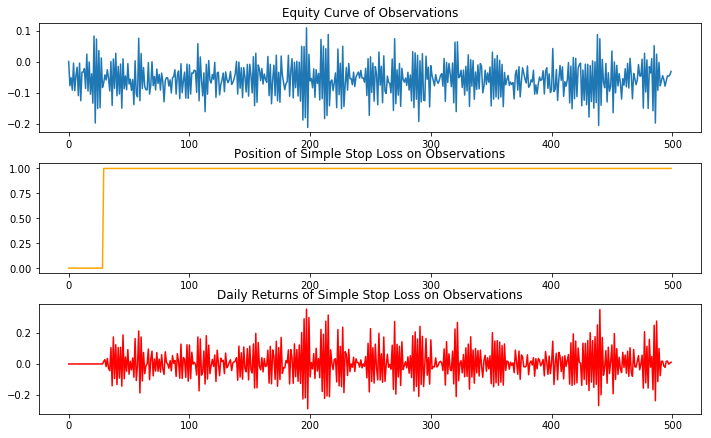

In [61]:
mean_reverting = obs.ARStopLoss(100, 15, -0.75, 500, .01, .3, 30, .03)
mean_reverting.plot()

### Evaluating Stop Loss on Momentum and Mean Reversion

In [62]:
momentum_daily_returns, momentum_pct_change = momentum.reveal_pnl()
stop_loss_returns = np.sum(momentum_daily_returns)
normal_returns = np.sum(momentum_pct_change)
print('Momentum Returns with Stop Loss:', stop_loss_returns)
print('Momentum Returns without Stop Loss:', normal_returns)
print('Difference:', stop_loss_returns - normal_returns)

Momentum Returns with Stop Loss: 0.49664771654667667
Momentum Returns without Stop Loss: 0.40670995294126
Difference: 0.08993776360541667


In [63]:
reverting_daily_returns, reverting_pct_change = mean_reverting.reveal_pnl()
stop_loss_returns = np.sum(reverting_daily_returns)
normal_returns = np.sum(reverting_pct_change)
print('Mean Reverting Returns with Stop Loss:', stop_loss_returns)
print('Mean Reverting Returns without Stop Loss:', normal_returns)
print('Difference:', stop_loss_returns - normal_returns)

Mean Reverting Returns with Stop Loss: 2.9251366869227535
Mean Reverting Returns without Stop Loss: 3.1117976671596925
Difference: -0.186660980236939


## Proposition 3: Two-State Markov Regime-Switching

In [75]:
mu = np.array([0, 10])
eps = np.array([2, 2])
A = np.array([[.7, .3], [.3, .7]])
regime = obs.RegimeStopLoss(mu, eps, A, 500)

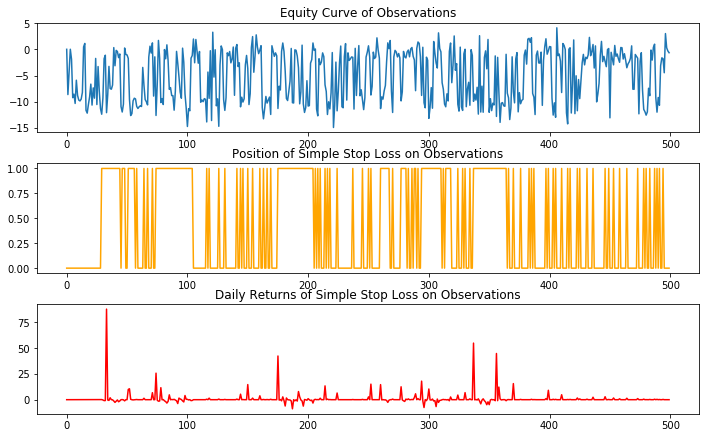

In [76]:
regime.plot()

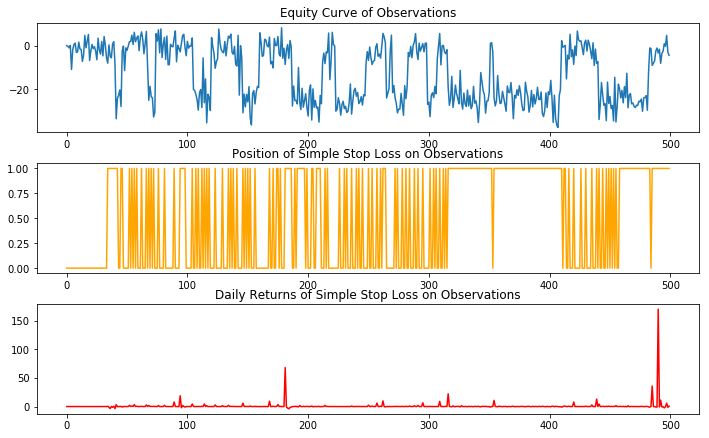

In [78]:
mu = np.array([0, 10])
eps = np.array([2, 2])
alt_A = np.array([[.95, .05], [.05, .95]])
alt_regime = obs.RegimeStopLoss(mu, eps, alt_A, 500)
alt_regime.plot()